# Import Libraries

In [46]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import torch.optim as optim
from datetime import datetime
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.utils as nn_utils
from IPython.display import clear_output
import torchvision.transforms as transforms
from skimage.metrics import peak_signal_noise_ratio as psnr
from torch.utils.data import Dataset, DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Create Data

In [89]:
from PIL import Image, ImageFile
import os

# Handle large or truncated images
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

def clear_image_folder(folder_path):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp')
    deleted_files = 0
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(image_extensions):
            try:
                os.remove(os.path.join(folder_path, filename))
                deleted_files += 1
            except Exception as e:
                print(f"Failed to delete {filename}: {e}")
    print(f"Deleted {deleted_files} image(s) from '{folder_path}'.")

def segment_image(lowres_image_path, lowres_output_path_dir, highres_image_path, highres_output_path_dir, degree):
    highres_img = Image.open(highres_image_path).convert("L")
    lowres_img = Image.open(lowres_image_path).convert("L").resize(highres_img.size)

    # Calculate the width and heigh according to set degree size
    degree_width = 360 // degree
    degree_height = 180 // degree

    width, height = highres_img.size
    width -= width % degree_width
    height -= height % degree_height

    tile_width = width // degree_width
    tile_height = height // degree_height

    highres_pixels = highres_img.load()
    tile_count = 0

    for x_tile in range(degree_width):
        for y_tile in range(degree_height):
            left = x_tile * tile_width
            upper = y_tile * tile_height
            right = left + tile_width
            lower = upper + tile_height

            black_pixel_count = 0

            for x in range(left, right):
                for y in range(upper, lower):
                    intensity = highres_pixels[x, y]  # 0 (black) to 255 (white)
                    if intensity < 10:
                        black_pixel_count += 1

            black_ratio = black_pixel_count / (tile_width * tile_height)

            if black_ratio > 0.01:
                continue  # Skip mostly black tiles

            # Save grayscale tiles
            highres_tile = highres_img.crop((left, upper, right, lower))
            lowres_tile = lowres_img.crop((left, upper, right, lower))

            filename = f"tile_{x_tile}_{y_tile}.jpg"
            highres_tile.save(os.path.join(highres_output_path_dir, filename))
            lowres_tile.save(os.path.join(lowres_output_path_dir, filename))
            tile_count += 1

    percent = round(100 * tile_count / (72 * 36), 1)
    print(f"Finished: Saved {tile_count} tiles ({percent}% coverage)")

degree = 5
generate = True

if generate:
    clear_image_folder("training/lowres")
    clear_image_folder("training/highres")
    
    segment_image(
        "references/lowres.tif", "training/lowres",
        "references/highres.tif", "training/highres",
        degree
    )

Deleted 0 image(s) from 'training/lowres'.
Deleted 0 image(s) from 'training/highres'.
Finished: Saved 484 tiles (18.7% coverage)


# Prepare Dataset

In [3]:
class PairedDataset(Dataset):
    def __init__(self, inputs_dir, targets_dir, transform_input=None, transform_target=None, nth=1):
        self.inputs_dir = inputs_dir
        self.targets_dir = targets_dir
        self.transform_input = transform_input
        self.transform_target = transform_target

        # Only take image files with valid extensions and skip hidden/system dirs
        valid_extensions = (".png", ".jpg")
        all_filenames = sorted([
            f for f in os.listdir(inputs_dir)
            if f.lower().endswith(valid_extensions) and not f.startswith(".")
        ])

        self.input_filenames = all_filenames[::nth]

    def __len__(self):
        return len(self.input_filenames)

    def __getitem__(self, idx):
        input_path = os.path.join(self.inputs_dir, self.input_filenames[idx])
        target_path = os.path.join(self.targets_dir, self.input_filenames[idx])  # assumes matching filenames

        input_img = Image.open(input_path).convert("L")
        target_img = Image.open(target_path).convert("L")

        if self.transform_input:
            input_img = self.transform_input(input_img)
        if self.transform_target:
            target_img = self.transform_target(target_img)

        return input_img, target_img

# UNET Model

In [25]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNetEnhancer(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512, 1024]):
        super().__init__()
        self.encoder = nn.ModuleList()
        # Downsampling parts (encoder)
        current_in_channels = in_channels
        for feature in features:
            self.encoder.append(DoubleConv(current_in_channels, feature))
            current_in_channels = feature

        # Max pooling for downsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        self.decoder = nn.ModuleList()
        # Upsampling and concatenation parts (decoder)
        # Iterate through features in reverse order
        # First upsampling: from bottleneck (features[-1]*2) to features[-1]
        # Then subsequent upsampling: from features[i+1] to features[i]

        # We start with the bottleneck's output channels for the first ConvTranspose2d
        # Then, each subsequent ConvTranspose2d's input channels will be the output channels of the DoubleConv
        # in the previous decoder block, which is `features[i+1]` if we use a consistent pattern.
        # However, a common U-Net design is that the DoubleConv in the decoder *outputs* `features[i]`.
        # So the next ConvTranspose2d needs to take `features[i]` as input for its upsampling.

        # Let's adjust the decoder initialization to reflect this.
        # The input channels to ConvTranspose2d should be the output channels of the *previous* DoubleConv.
        # The output channels of ConvTranspose2d should be `features[i]`.
        # The subsequent DoubleConv will then take `features[i]*2` (upsampled + skip)

        # First ConvTranspose (from bottleneck)
        self.decoder.append(
            nn.ConvTranspose2d(
                features[-1] * 2, # Input channels from bottleneck
                features[-1],    # Output channels to match first skip connection
                kernel_size=2,
                stride=2,
            )
        )
        self.decoder.append(DoubleConv(features[-1] * 2, features[-1])) # DoubleConv after first upsample+concat

        # Remaining ConvTranspose and DoubleConv blocks
        for i in reversed(range(len(features) - 1)): # i will be len(features)-2 down to 0
            # features[i] will be 128, 64 (for a features=[64,128,256])
            # features[i+1] will be 256, 128 (corresponding to previous output)

            # ConvTranspose2d input: output of previous DoubleConv, which is `features[i+1]`
            self.decoder.append(
                nn.ConvTranspose2d(
                    features[i+1], # Input channels: output from previous DoubleConv
                    features[i],   # Output channels: to match skip connection
                    kernel_size=2,
                    stride=2,
                )
            )
            # DoubleConv input: `features[i]` (from ConvTranspose2d) + `features[i]` (from skip) = `features[i]*2`
            self.decoder.append(DoubleConv(features[i] * 2, features[i]))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.final_activation = nn.Sigmoid() # Add this for [0,1] output range

    def forward(self, x):
        skip_connections = []

        # Encoder path
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x) # Store the output before pooling
            x = self.pool(x) # Apply pooling after each encoder block

        x = self.bottleneck(x) # x has features[-1]*2 channels

        # Reverse skip connections for easy access (from deepest to shallowest)
        skip_connections = skip_connections[::-1]

        # Decoder path
        # Iterate through the decoder modules in pairs: ConvTranspose and DoubleConv
        for i in range(0, len(self.decoder), 2):
            up_layer = self.decoder[i]      # ConvTranspose2d
            conv_layer = self.decoder[i+1]  # DoubleConv

            x = up_layer(x) # x is correctly passed here

            # Get the correct skip connection: i//2 gives 0, 1, 2 for decoder blocks
            # skip_connections[0] for first decoder block (corresponding to features[-1])
            # skip_connections[1] for second decoder block (corresponding to features[-2])
            # etc.
            skip_idx = i // 2
            current_skip = skip_connections[skip_idx]

            # Adjust padding if spatial dimensions don't match exactly due to pooling/upsampling
            if x.shape[2:] != current_skip.shape[2:]: # Compare only H, W
                x = transforms.CenterCrop(current_skip.shape[2:])(x) # Crop upsampled feature map if needed

            # Concatenate skip connection
            concat_skip = torch.cat((current_skip, x), dim=1)
            x = conv_layer(concat_skip) # Apply DoubleConv to concatenated features

        out = self.final_conv(x)
        out = self.final_activation(out)

        return out


# Discriminator

In [132]:
# --- Discriminator Network ---
class Discriminator(nn.Module):
    def __init__(self, in_channels=2, features=[64, 128, 256]):
        super().__init__()
        # PatchGAN Discriminator (similar to a series of Conv2d layers)
        # It concatenates input_img and generated_img along the channel dimension.
        # So, if input_img and generated_img are 1 channel each, in_channels will be 2.

        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True) # LeakyReLU for discriminator to avoid dying ReLUs
        )

        layers = []
        in_feature = features[0]
        for feature in features[1:]:
            layers += [
                nn.Conv2d(in_feature, feature, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(feature),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            in_feature = feature

        # Last layer: output 1 channel (for 'real'/'fake' classification per patch)
        layers.append(nn.Conv2d(in_feature, 1, kernel_size=4, stride=1, padding=1, bias=False)) # Stride 1 for last layer
        # No sigmoid here, it's applied in the loss function (BCEWithLogitsLoss)

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # x will be the concatenated input_img and (target_img or generated_img)
        x = self.initial(x)
        x = self.model(x)
        return x

# --- Helper function to initialize weights (Good practice for GANs) ---
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02) # Mean 0, Std Dev 0.02
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Perceptual Loss

In [6]:
class PerceptualLoss(nn.Module):
    def __init__(self, device, layer_weights=None): # Add device parameter
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features.to(device) # Move VGG to device
        self.blocks = nn.ModuleList([
            vgg[:4].eval(),   # relu1_2
            vgg[4:9].eval(),  # relu2_2
            vgg[9:16].eval()  # relu3_3
        ])

        for block in self.blocks:
            for param in block.parameters():
                param.requires_grad = False

        self.transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

        self.layer_weights = layer_weights or [1.0, 0.75, 0.2]
        self.criterion = nn.L1Loss()

    def forward(self, gen, target):
        # Convert to 3-channel RGB for VGG
        gen = gen.repeat(1, 3, 1, 1)
        target = target.repeat(1, 3, 1, 1)

        # The inputs gen and target are already on the correct device because they were moved in the training loop
        gen = self.transform(gen)
        target = self.transform(target)

        loss = 0.0
        for i, block in enumerate(self.blocks):
            # The block is now on the same device as gen and target
            gen = block(gen)
            target = block(target)
            loss += self.layer_weights[i] * self.criterion(gen, target)
        return loss

# Training Algorithm

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return f'{self.__class__.__name__}(mean={self.mean}, std={self.std})'

def show_images(input_img, output_img, target_img):
    input_img = input_img.squeeze().detach().cpu()
    output_img = output_img.squeeze().detach().cpu()
    target_img = target_img.squeeze().detach().cpu()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(input_img, cmap='gray')
    axs[0].set_title("Input")
    axs[0].axis('off')

    axs[1].imshow(output_img, cmap='gray')
    axs[1].set_title("Output")
    axs[1].axis('off')

    axs[2].imshow(target_img, cmap='gray')
    axs[2].set_title("Target")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

# --- Helper function to initialize weights ---
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Check if the module actually has a weight attribute (it might be a container)
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        # Check if the module actually has weight and bias attributes
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

def calculate_psnr(fake, target, max_pixel_value=1.0):
    mse = torch.mean((fake - target) ** 2)
    if mse == 0:
        return float('inf')
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()

# --- Training Function for GAN ---
def train_gan(generator, discriminator, train_dataloader, val_dataloader, opt_gen, opt_disc, criterion_gan, criterion_l1, device, epochs, save_path, lambda_l1):
    generator.train()
    discriminator.train()
    os.makedirs(save_path, exist_ok=True)

    g_losses = []
    d_losses = []
    val_g_losses = []
    epoch_psnr_values = []
    psnr_history = []

    for epoch in range(epochs):
        total_g_loss = 0
        total_d_loss = 0
        train_loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} (Train)", leave=True)

        lambda_gan = get_lambda_gan(epoch, total_epochs=epochs)

        # Freeze D if GAN loss not used
        if lambda_gan == 0:
            discriminator.eval()
            for p in discriminator.parameters():
                p.requires_grad = False
        else:
            discriminator.train()
            for p in discriminator.parameters():
                p.requires_grad = True

        for batch_idx, (input_img, target_img) in enumerate(train_loop):
            input_img, target_img = input_img.to(device), target_img.to(device)

            if lambda_gan > 0:
                # --- Train Discriminator ---
                opt_disc.zero_grad()

                D_real_input = torch.cat([input_img, target_img], dim=1)
                D_real_output = discriminator(D_real_input)
                real_labels = torch.ones_like(D_real_output).to(device)
                loss_D_real = criterion_gan(D_real_output, real_labels)

                with torch.no_grad():
                    generated_img_detached = generator(input_img).detach()
                fake_input_detached = torch.cat([input_img, generated_img_detached], dim=1)
                pred_fake_detached = discriminator(fake_input_detached)
                fake_labels = torch.zeros_like(pred_fake_detached).to(device)
                loss_D_fake = criterion_gan(pred_fake_detached, fake_labels)

                loss_D = (loss_D_real + loss_D_fake) / 2
                total_d_loss += loss_D.item()
                loss_D.backward()
                opt_disc.step()
            else:
                loss_D = torch.tensor(0.0, device=device)
                total_d_loss += 0.0

            # --- Train Generator ---
            opt_gen.zero_grad()
            generated_img = generator(input_img)

            if lambda_gan > 0:
                D_gen_output = discriminator(torch.cat([input_img, generated_img], dim=1))
                loss_G_adversarial = criterion_gan(D_gen_output, real_labels)
            else:
                loss_G_adversarial = torch.tensor(0.0, device=device)

            loss_G_l1 = criterion_l1(generated_img, target_img)
            loss_G = lambda_gan * loss_G_adversarial + lambda_l1 * loss_G_l1
            total_g_loss += loss_G.item()
            loss_G.backward()
            opt_gen.step()

            train_loop.set_postfix(G_loss=loss_G.item(), D_loss=loss_D.item())

        avg_g_loss = total_g_loss / len(train_dataloader)
        avg_d_loss = total_d_loss / len(train_dataloader)
        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)
        print(f"Epoch {epoch + 1} Avg G Loss: {avg_g_loss:.4f}, Avg D Loss: {avg_d_loss:.4f}")

        # --- Validation Phase ---
        generator.eval()
        discriminator.eval()
        total_val_g_loss = 0
        with torch.no_grad():
            val_loop = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} (Val)", leave=True)
            for input_img_val, target_img_val in val_loop:
                input_img_val, target_img_val = input_img_val.to(device), target_img_val.to(device)
                generated_img_val = generator(input_img_val)
                val_g_l1_loss = criterion_l1(generated_img_val, target_img_val)
                total_val_g_loss += val_g_l1_loss.item()
                val_loop.set_postfix(val_g_loss=val_g_l1_loss.item())

            clear_output(wait=True)
            rand_idx = random.randint(0, len(input_img_val)-1)
            show_images(input_img_val[rand_idx], generated_img_val[rand_idx], target_img_val[rand_idx]) # Use generated for visualization

            avg_val_g_loss = total_val_g_loss / len(val_dataloader)
            val_g_losses.append(avg_val_g_loss)
            print(f"Epoch {epoch + 1} Validation G Loss: {avg_val_g_loss:.4f}")

        generator.train()
        discriminator.train()

        psnr = calculate_psnr(generated_img_val, target_img_val)
        epoch_psnr_values.append(psnr)
        avg_psnr = sum(epoch_psnr_values) / len(epoch_psnr_values)
        psnr_history.append(avg_psnr)
        print(f"Epoch {epoch+1} Average PSNR: {avg_psnr:.2f} dB")

    # Current timestamp
    timestamp = datetime.now().strftime("%Y:%m:%d_%H:%M:%S")

    # Build filename
    gen_filename = f"generator_crater_ep{epochs}_{timestamp}.pth"
    disc_filename = f"discriminator_crater_ep{epochs}_{timestamp}.pth"
    
    torch.save(generator.module.state_dict(), os.path.join(save_path, gen_filename))
    torch.save(discriminator.module.state_dict(), os.path.join(save_path, disc_filename))
    print(f"Saved final Generator and Discriminator models to {save_path}")

    return g_losses, d_losses, val_g_losses, psnr_history


# Gradual increase of adversarial loss weight
def get_lambda_gan(epoch, total_epochs, warmup_epochs=100, max_lambda=0.001):
    if epoch < warmup_epochs:
        return 0.0
    else:
        return max_lambda * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)

# Main Block

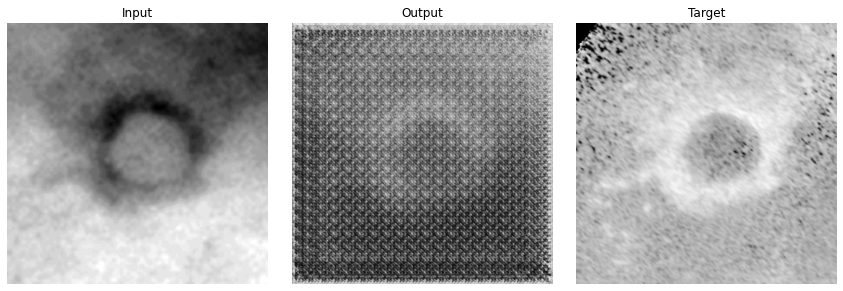

Epoch 100 Validation G Loss: 1.6760
Epoch 100 Average PSNR: 10.15 dB
Saved final Generator and Discriminator models to save


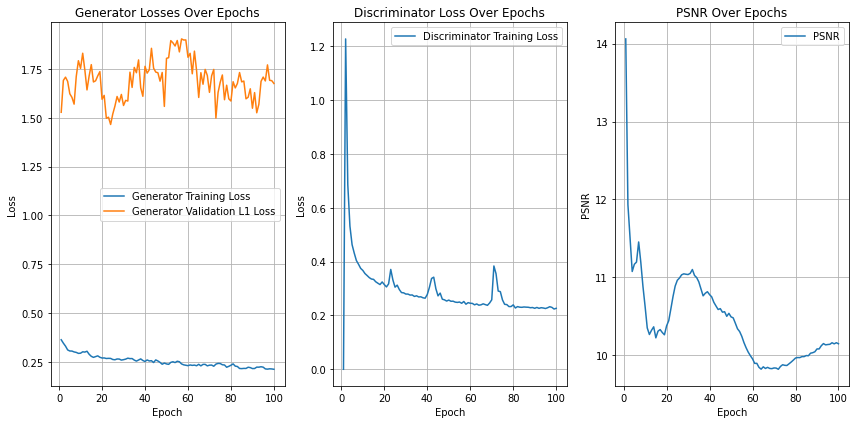

In [149]:
# --- Main Execution Block ---

# Training settings
LEARNING_RATE = 1e-4
EPOCHS = 100
BATCH_SIZE = 4
image_scalar = 1
LAMBDA_L1 = 0.5 # Balances L1 vs adversarial loss
run_train = True


inputs_folder = "training - crater/lowres"
targets_folder = "training - crater/highres"
save_folder = "save"

base_size = 128 * degree
scaled_size = int(base_size * image_scalar)

transform_input = transforms.Compose([
    transforms.Resize((scaled_size, scaled_size)),
    transforms.ToTensor(),
])

transform_target = transforms.Compose([
    transforms.Resize((scaled_size, scaled_size)),
    transforms.ToTensor(),
])

# Device setup
print(f"Using device: {device}")

# --- Dataset Splitting ---
# Using nth=1 is generally recommended if you want to use all available data
full_dataset = PairedDataset(inputs_folder, targets_folder, transform_input, transform_target, nth=1)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

if run_train:

    print(f"Dataset split: Train {len(train_dataset)} samples, Validation {len(val_dataset)} samples")
    print(f"Image dimensions (scaled): {scaled_size}x{scaled_size}")
    
    
    # --- Models ---
    # generator = UNetEnhancer(in_channels=1, out_channels=1).to(device)
    # generator = nn.DataParallel(generator).to(device)
    # Discriminator input_channels are 2 (input_img + target_img/generated_img)
    discriminator = Discriminator(in_channels=2).to(device)
    discriminator = nn.DataParallel(discriminator).to(device) 
    
    # Initialize weights for both G and D
    # generator.apply(init_weights)
    discriminator.apply(init_weights)
    print("Generator and Discriminator models initialized with custom weights.")
    
    # --- Losses ---
    criterion_gan = nn.MSELoss() # nn.BCEWithLogitsLoss() # For adversarial loss
    criterion_l1 = PerceptualLoss(device) # Perceptual Loss
    # Could use Strucutral Similarity, Perceptual Loss (better option? May not be implemented into nn, may need to manually add).
    # 314 L2 R232 -> Computing Building
    
    # Library called
    # Hugging Face -> Diffusers Library -> Train Diffusion models
    
    # --- Optimizers ---
    # Common beta values for Adam in GANs (0.5, 0.999)
    opt_gen = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    opt_disc = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    
    
    print("Starting GAN training...")
    g_losses, d_losses, val_g_losses, psnr_history = train_gan(
        generator,
        discriminator,
        train_dataloader,
        val_dataloader,
        opt_gen,
        opt_disc,
        criterion_gan,
        criterion_l1,
        device,
        epochs=EPOCHS,
        save_path=save_folder,
        lambda_l1=LAMBDA_L1
    )
    
    # --- Plotting Losses ---
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.plot(range(1, EPOCHS + 1), g_losses, label='Generator Training Loss')
    plt.plot(range(1, EPOCHS + 1), val_g_losses, label='Generator Validation L1 Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator Losses Over Epochs')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(range(1, EPOCHS + 1), d_losses, label='Discriminator Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Discriminator Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(range(1, EPOCHS + 1), psnr_history, label='PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.title('PSNR Over Epochs')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Validation

Saved enhanced image: test/upscaled/crater-2.jpg
Saved enhanced image: test/upscaled/crater-3.jpg
Saved enhanced image: test/upscaled/crater.jpg


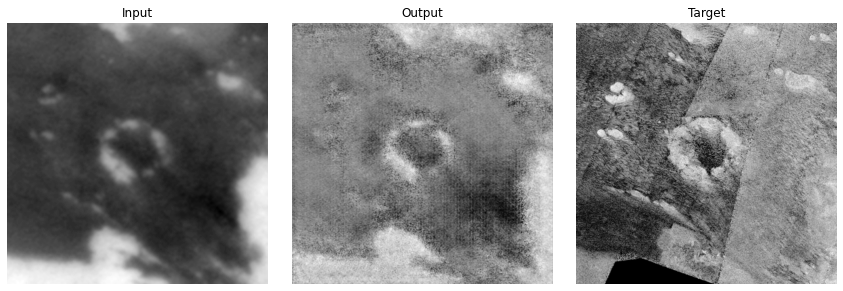

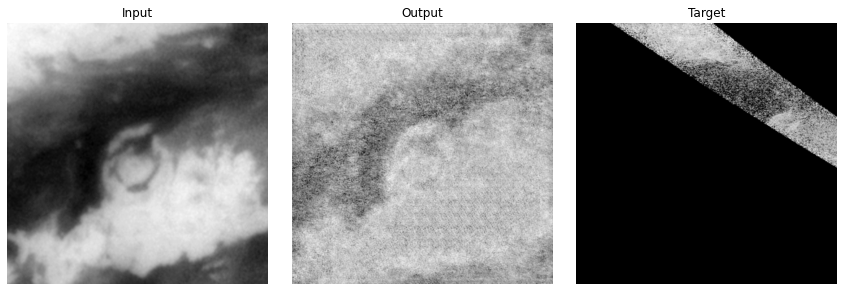

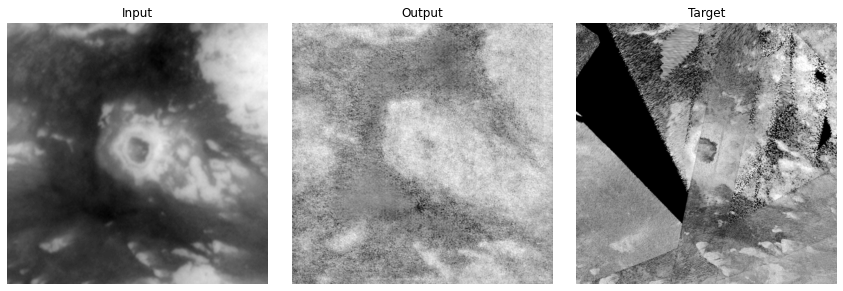

In [148]:
def test_and_save_folder(model, input_folder, output_folder, target_folder, device, output_size=(64, 64), display_num=3):
    model.eval()
    os.makedirs(output_folder, exist_ok=True)
    transform_input = transforms.Compose([
        transforms.Resize(output_size),
        transforms.ToTensor(),
    ])
    to_pil = transforms.ToPILImage()

    inputs_to_show = []
    outputs_to_show = []
    targets_to_show = []

    for idx, filename in enumerate(sorted(os.listdir(input_folder))):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
            continue

        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        input_img = Image.open(input_path).convert("L")
        input_tensor = transform_input(input_img).unsqueeze(0).to(device)

        with torch.no_grad():
            output_tensor = model(input_tensor)

        output_tensor = output_tensor.squeeze(0).cpu().clamp(0, 1)
        output_img = to_pil(output_tensor)

        if output_size is not None:
            output_img = output_img.resize(output_size, resample=Image.BILINEAR)

        output_img.save(output_path)
        print(f"Saved enhanced image: {output_path}")

        # Load target image if folder provided
        if target_folder is not None:
            target_path = os.path.join(target_folder, filename)
            if os.path.exists(target_path):
                target_img = Image.open(target_path).convert("L")
                target_tensor = transform_input(target_img).unsqueeze(0).to(device)
            else:
                print(f"Warning: Target not found for {filename}")
                target_tensor = torch.zeros_like(input_tensor)  # fallback if missing
        else:
            target_tensor = None

        # Collect first few for display
        display_num += 1
        if idx < display_num:
            inputs_to_show.append(input_tensor)
            outputs_to_show.append(output_tensor.unsqueeze(0))  # add batch dim for show_images
            targets_to_show.append(target_tensor)

    # Display results for first display_num images
    for inp, outp, targ in zip(inputs_to_show, outputs_to_show, targets_to_show):
        show_images(inp, outp, targ)

# Usage example:
test_and_save_folder(generator, "test/lowres", "test/upscaled", "test/highres", device, output_size=(base_size, base_size), display_num=3)

# Load .pth

In [130]:
generator = UNetEnhancer(in_channels=1, out_channels=1).to(device)

if torch.cuda.device_count() > 1:
    generator = torch.nn.DataParallel(generator)

generator.to(device)

# Load state dict
gen_filename = "generator_base_variant2.pth"
state_dict = torch.load(os.path.join("save", gen_filename), map_location=device)

# Load into the right place:
if isinstance(generator, torch.nn.DataParallel):
    generator.module.load_state_dict(state_dict)
else:
    generator.load_state_dict(state_dict)

<ipython-input-130-473702a65759>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join("save", gen_filename), map_location=device)


# Accuracy

In [142]:
def evaluate_psnr(loader, model, device="cuda"):
    model.eval()
    psnr_values = []

    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Evaluating PSNR"):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs).clamp(0, 1)

            # Move to CPU and convert to numpy
            outputs_np = outputs.cpu().numpy()
            targets_np = targets.cpu().numpy()

            for i in range(outputs_np.shape[0]):
                pred_img = outputs_np[i][0]    # [H, W] if grayscale
                target_img = targets_np[i][0]  # [H, W]

                psnr_val = psnr(target_img, pred_img, data_range=1.0)
                psnr_values.append(psnr_val)

    avg_psnr = sum(psnr_values) / len(psnr_values)
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    model.train()

evaluate_psnr(val_dataloader, generator, device)

Evaluating PSNR: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

Average PSNR: 15.22 dB


In [146]:
import shutil

shutil.make_archive("my_folder_backup", 'zip', "comparison_plots")

'/home/ubuntu/Desktop/titan-env/model/my_folder_backup.zip'